

# Hyperparameter Optimization

In [74]:
import torch
import torch.nn as nn
import pandas as pd
import os
import platform
import matplotlib.pyplot as plt
import sklearn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_decision(X,y,model,size =(8,8),
                  output_class = False,
                  pt = False, device='cpu',
                  text_pred=False,
                  softmax=False):

  h = .02  # step size in the mesh

  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

  fig, ax = plt.subplots(figsize=size)

  if pt:
    model.eval()

    input = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)
    outputs = model(input)
    if softmax:
      outputs = outputs.data.max(1, keepdim=True)[1]
    Z = outputs.detach().cpu().numpy()


    Xt = torch.from_numpy(X).to(device).float()
    pred = model(Xt)

    if not softmax:
      pred = np.where(pred.detach().cpu().numpy() > 0.5, 1, 0).flatten()
    else:
      pred  =  pred.detach().cpu().numpy().flatten()


  else:

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

  if output_class:
    Z = Z >0.5

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z)
  ax.axis('on')

  # Plot test points
  ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
  if text_pred:
    plt.title(f'pred: {pred}')
  plt.show()

In [64]:
# cwd = os.getcwd() + "/MHEALTHDATASET_CSV"
if(platform.system() == 'Windows'):
    cwd = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV'
else:
    cwd = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(cwd)

os.chdir(cwd)

#split data into sections by label

df = pd.DataFrame()
dataframes = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{cwd}/{file}"
        temp = pd.read_csv(file_path)
        dataframes.append(temp)
        print('file:', file, '| size = ', len(temp))
        
df = pd.concat(dataframes)

C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTHDATASET_CSV


file: mHealth_subject1.csv | size =  161280
file: mHealth_subject10.csv | size =  98304
file: mHealth_subject2.csv | size =  130561
file: mHealth_subject3.csv | size =  122112
file: mHealth_subject4.csv | size =  116736
file: mHealth_subject5.csv | size =  119808
file: mHealth_subject6.csv | size =  98304
file: mHealth_subject7.csv | size =  104448
file: mHealth_subject8.csv | size =  129024
file: mHealth_subject9.csv | size =  135168


In [65]:
#extracts x,y,z chest accel data into different label groups
def partition_data(label, dataframe):
    x_data = []
    y_data = []
    z_data = []
    activity = []
    
    for i in range(len(dataframe)):
        if(df['label'].iloc[i] == label):
            x_data.append(df['chest acceleration X-axis'].iloc[i])
            y_data.append(df['chest acceleration Y-axis'].iloc[i])
            z_data.append(df['chest acceleration Z-axis'].iloc[i])
            activity.append(df['label'].iloc[i])
            
    
    partitioned_df = pd.DataFrame(
                                  {
        'x-axis': x_data,
        'y-axis': y_data,
        'z-axis': z_data,
        'label': activity
                                  })
    
    return partitioned_df

In [66]:
#splitting all mhealth data based on label, used for classification
df_null = partition_data(0, df)
df_stand = partition_data(1, df) 
df_sit = partition_data(2, df)
df_lying = partition_data(3, df)
df_walk = partition_data(4, df)
df_stairs = partition_data(5, df)
df_waist_bend = partition_data(6, df)
df_arms = partition_data(7, df) 
df_knee_bend = partition_data(8, df) 
df_cycle = partition_data(9, df) 
df_jog = partition_data(10, df) 
df_run = partition_data(11, df) 
df_jump = partition_data(12, df) 

In [67]:
print(df_null)

         x-axis    y-axis    z-axis  label
0       -9.8184  0.009971  0.295630    0.0
1       -9.8489  0.524040  0.373480    0.0
2       -9.6602  0.181850  0.437420    0.0
3       -9.6507  0.214220  0.240330    0.0
4       -9.7030  0.303890  0.311560    0.0
...         ...       ...       ...    ...
872545 -12.2440 -2.970600 -0.035772    0.0
872546 -10.9220 -3.419000 -0.339280    0.0
872547  -9.4842 -3.064300 -1.033700    0.0
872548  -8.7889 -2.475700 -0.612290    0.0
872549  -8.6851 -1.098500  0.153770    0.0

[872550 rows x 4 columns]


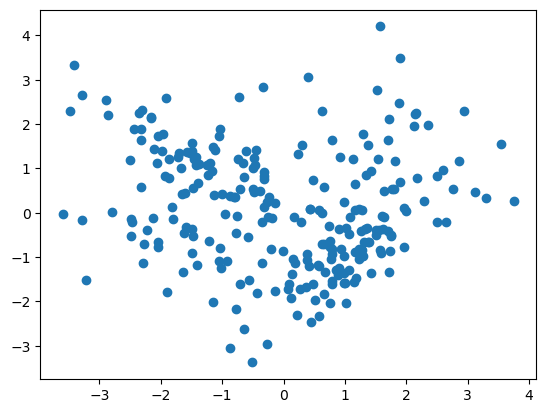

In [30]:
# from sklearn.datasets import make_classification
# 
# from sklearn.model_selection import train_test_split

# X, y = make_classification(
#     n_samples=1000,n_features=2,n_classes=4,n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
# )

# #random_state: Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# plt.scatter(X_test[:,0], X_test[:,1])
# plt.show()

In [91]:
def accuracy(model, X, y):
  pred = model(X)
  _, predicted = torch.max(pred.data, 1)
  n_correct = torch.sum(predicted == y)
  total = y.size(0)
  print('Accuracy: %d %%' % (100 * n_correct / total))

X_data = df_null['x-axis'].to_numpy()
y_data = df_null['label'].to_numpy()

split_idx = int(len(X_data) * 0.8)

X_train = X_data[:split_idx]
y_train = y_data[:split_idx]

X_t = torch.from_numpy(X_data[:split_idx]).to(device)
y_t = torch.from_numpy(y_data[split_idx:]).to(device)


In [96]:
print(type(X_train[0]))
print(type(y_train[0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [79]:
class Net(nn.Module):

    def __init__(self, input_dim=2, num_classes=13, num_units=8, dropout=0.5, hidden=True):
        super(Net, self).__init__()
        self.fcin = nn.Linear(input_dim, num_units)
        self.fchidden = nn.Linear(num_units, num_units)
        self.fcout = nn.Linear(num_units, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.act = torch.nn.ReLU()
        self.h = hidden


    def forward(self, x):
        x = self.act(self.fcin(x))
        if self.h:
          x = self.act(self.fchidden(x))
        x = self.dropout(x)
        x = self.fcout(x)
        return x

In [80]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    Net,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss()

)

In [88]:
print(type(X_train[0]))

<class 'numpy.float64'>


In [93]:
from sklearn.model_selection import GridSearchCV


# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.001, 0.001],
    'max_epochs': [10, 20, 50],
    'module__num_units': [32, 64],
    'module__dropout': [0.1],
    'module__input_dim': [2],
    'module__num_classes': [13],
    'module__hidden': [True, False]

}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=0)

gs.fit(X_train, y_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

ValueError: 
All the 72 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\optimizer.py", line 391, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\adam.py", line 148, in step
    loss = closure()
           ^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 993, in train_step_single
    y_pred = self.infer(Xi, **fit_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1521, in infer
    return self.module_(x, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_13664\988837281.py", line 14, in forward
    x = self.act(self.fcin(x))
                 ^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\linear.py", line 116, in forward
    return F.linear(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float


In [85]:
params = gs.best_params_
params

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [37]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping,LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

acc = EpochScoring(scoring='accuracy')


net = NeuralNetClassifier(
    Net,
    lr = params['lr'],
    max_epochs=params['max_epochs'],
    module__dropout = params['module__dropout'],
    module__num_units = params['module__num_units'],
    module__hidden = params['module__hidden'],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    callbacks=[acc],

)

In [38]:
net

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net'>,
  module__dropout=0.1,
  module__hidden=True,
  module__num_units=64,
)

In [39]:
net.fit(X_train, y_train)

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4533        1.3478       0.4533        1.2822  0.0254
      2      0.6800        1.2313       0.6800        1.1964  0.0251
      3      0.6733        1.1294       0.6733        1.1236  0.0201
      4      0.7067        1.0448       0.7067        1.0600  0.0200
      5      0.7200        0.9667       0.7200        1.0040  0.0210
      6      0.7067        0.8994       0.7067        0.9569  0.0258
      7      0.6933        0.8427       0.6933        0.9169  0.0230
      8      0.6733        0.7917       0.6733        0.8843  0.0208
      9      0.6800        0.7517       0.6800        0.8586  0.0199
     10      0.6667        0.7168       0.6667        0.8383  0.0248
     11      0.6733        0.6893       0.6733        0.8238  0.0208
     12      0.6667        0.6757       0.6667        0.8124  0.0211
     13      0.6800        0.6561 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (fcin): Linear(in_features=2, out_features=64, bias=True)
    (fchidden): Linear(in_features=64, out_features=64, bias=True)
    (fcout): Linear(in_features=64, out_features=4, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (act): ReLU()
  ),
)

In [40]:
class Net(nn.Module):

    def __init__(self, input_dim=2, num_classes=4, num_units=8, dropout=0.5, hidden=True):
        super(Net, self).__init__()
        self.fcin = nn.Linear(input_dim, num_units)
        self.fchidden = nn.Linear(num_units, num_units)
        self.fcout = nn.Linear(num_units, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.act = torch.nn.ReLU()
        self.h = hidden


    def forward(self, x):
        x = self.act(self.fcin(x))
        if self.h:
          x = self.act(self.fchidden(x))
        x = self.dropout(x)
        x = self.fcout(x)
        return x

In [41]:
import torch.utils.data as data_utils

train = data_utils.TensorDataset(X_train,y_train)
train_loader = data_utils.DataLoader(train , batch_size=64 , shuffle=True)
criterionCE = nn.CrossEntropyLoss()

def run(model, num_epochs, learning_rate=0.01, bench=True):
  model = model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  model.train()

  for i in range(0, num_epochs):
    for batch_idx,(data , labels) in enumerate(train_loader):
      data = data.to(device)
      labels = labels.to(device)
      labels = labels.to(torch.int64)
      outputs = model(data)

      loss = criterionCE(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  if bench:
    print(f'training completed in {end-start}s')

  return model

In [42]:
net = Net(2,4,
          num_units=params['module__num_units'],
          dropout=params['module__dropout'],
          hidden=params['module__hidden']
          )

model = run(net,
            60,
            learning_rate=params['lr'],
            bench=False)

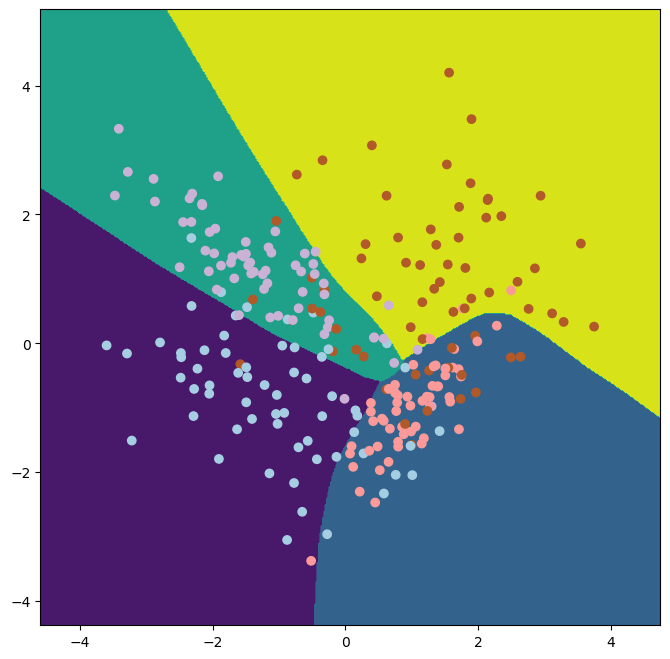

In [43]:
plot_decision(X_t.cpu().numpy(),y_t.cpu().numpy(),model, output_class=False, pt = True, device='cuda', softmax=True)

In [44]:
accuracy(model,X_t,y_t)

Accuracy: 79 %
